# Food Vision Milestone Project


Goals
- Beat [DeepFood](https://www.researchgate.net/publication/304163308_DeepFood_Deep_Learning-Based_Food_Image_Recognition_for_Computer-Aided_Dietary_Assessment) (2016 paper which used CNN trained for 2-3 days to achieve 77.4% top-1 accuracy)

How:
- TensorFlow Datasets to download and explore data
- Creating preprocessing functions for data
- Batching and preparing datasets for modeling
- Creating modelling callbacks
- Setting up mixed precision training
  - Mixed precision training uses a combination of single precision (float32) and half-preicison (float16) data types to speed up model training (up 3x on modern GPUs)
- Building a feature extraction model
- Fine-tuning the feature extraction model
- View training results on TensorBoard


In [ ]:
# Using Google Colab, this should output "Tesla T4" otherwise, won't be able to use mixed precision training
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-882dbcf8-93bf-1dc4-6e6f-d2940610debb)


In [ ]:
# Check TensorFlow version (should be 2.4.0+)
import tensorflow as tf

print(tf.__version__)

2.11.0


# Get Helper Functions

In [ ]:
import os

if not os.path.exists('helper_functions.py'):
  !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else: 
  print("[INFO] 'helper_functions.py' already exists, skipping download.")

--2023-02-27 00:54:17--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-02-27 00:54:17 (78.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

'''
create_tensorboard_callback 
  - Creates a TensorBoard callback instand to store log files. Stores log files with the filepath: "dir_name/experiment_name/current_datetime/"

plot_loss_curves
  - Returns separate loss curves for training and validation metrics.

compare_historys
  - Compares two TensorFlow model History objects.

'''

# Use TensorFlow Datasets to Download Data

**TensorFlow Datasets** is a place for prepared and ready-to-use machine learning datasets

Pros:
- Load data already in Tensors
- Practice on well established datasets
- Experiment with different data loading techniques
- Experiment with new TensorFlow features 

Cons:
- Datasets are static (don't change like real-world datasets would)
- Might not be suited for particular problem

In [ ]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [ ]:
# List available datasets
dataset_list = tfds.list_builders() # Get all available datasets in TFDS
print("food101" in dataset_list) # Check if our dataset is available

True


# Accessing the Food101 dataset from TFDS

Few parameters to pass to access the dataset

* name (str) : the target dataset
* splt (list, optional) : what splits of the dataset we're after (e.g. ['train', 'validation']
* shuffle_files (bool) : whether or not to shuffle the files on download, default is False
* as_supervised (bool) : True - to download data samples in tuple format ((data, level)) or False - for dictionary format
* with_info (bool) : True - to donload dataset metadata (labels, number of samples, etc)

In [ ]:
# Load in the data
(train_data, test_data), ds_info = tfds.load(name='food101', # target dataset from TFDS
                                             split=['train', 'validation'], # what splits of data we're after
                                             shuffle_files=True, # shuffle files on download 
                                             as_supervised=True, # download files in tuple format
                                             with_info=True) # include dataset metadata

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteFCAN25/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteFCAN25/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
# Features of Food101 TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [ ]:
# Get class names
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

# Exploring the Food101 data from TFDS

In [ ]:
# Take one sample of the training data
train_one_sample = train_data.take(1) # Sample are in format since we set as_supervised=True (image_tensor, label)

In [ ]:
# View sample
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# Get output info for the sample
for image, label in train_one_sample:
  print(f"""
        Image Shape: {image.shape}
        Image dtype: {image.dtype}
        Target class from Food101 (tensor form): {label}
        Class name (str form): {class_names[label.numpy()]}
        """)


        Image Shape: (512, 512, 3)
        Image dtype: <dtype: 'uint8'>
        Target class from Food101 (tensor form): 23
        Class name (str form): churros
        


In [ ]:
# Check out image tensor
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 93,  34,  40],
        [ 93,  34,  40],
        [ 94,  35,  41],
        ...,
        [ 52,  15,  23],
        [ 52,  15,  23],
        [ 52,  15,  23]],

       [[ 93,  34,  40],
        [ 93,  34,  40],
        [ 94,  35,  41],
        ...,
        [ 52,  15,  23],
        [ 52,  15,  23],
        [ 52,  15,  23]],

       [[ 93,  34,  40],
        [ 93,  34,  40],
        [ 94,  35,  41],
        ...,
        [ 54,  14,  23],
        [ 52,  15,  23],
        [ 52,  15,  23]],

       ...,

       [[108,  31,  49],
        [106,  29,  47],
        [105,  28,  46],
        ...,
        [121,  38,  56],
        [122,  39,  59],
        [123,  40,  60]],

       [[107,  30,  48],
        [107,  30,  48],
        [107,  30,  48],
        ...,
        [121,  38,  58],
        [123,  40,  60],
        [123,  40,  60]],

       [[106,  29,  47],
        [108,  31,  49],
        [109,  32,  50],
        ...,
        [123,  40,  6

In [ ]:
# What are the min and max values?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=9>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

Image tensors have values between 0 to 255 (Red, Green, Blue color values) and value are type unit8

# Plot an image from TensorFlow Datasets

(-0.5, 511.5, 511.5, -0.5)

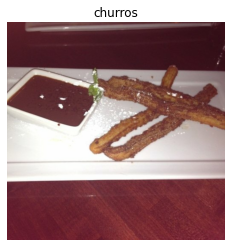

In [ ]:
# Plot the previous image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) 
plt.axis(False)

# Create preprocessing function for our data

We have to process the image data from TensorFlow Datasets 

Our data is currently:
- In unit8 data type
- Comprised of all different sized tensors (different sized tensors)
- Not scaled (pixel values are 0 to 255)


Models prefer data to be:
- In float32 data type
- Same sized tensors (tensors to be same shape)
- Scaled (pixel values 0 to 1) aka normalized

In [ ]:
# Make a function to preprocess images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype to float32 and reshape image to [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [ ]:
# Preprocess the single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]

print(f"Image before preprocessing:\n {image[:2]}")
print(f"Shape: {image.shape}")
print(f"Datatype: {image.dtype}")
print()
print(f"Image after preprocessing:\n {preprocessed_img[:2]}")
print(f"Shape: {preprocessed_img.shape}")
print(f"Datatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[93 34 40]
  [93 34 40]
  [94 35 41]
  ...
  [52 15 23]
  [52 15 23]
  [52 15 23]]

 [[93 34 40]
  [93 34 40]
  [94 35 41]
  ...
  [52 15 23]
  [52 15 23]
  [52 15 23]]]
Shape: (512, 512, 3)
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[93.       34.       40.      ]
  [94.       35.       41.      ]
  [95.       36.       42.      ]
  ...
  [55.       15.       24.      ]
  [52.       15.       23.      ]
  [52.       15.       23.      ]]

 [[93.92857  34.928574 40.928574]
  [93.07143  34.071426 40.071426]
  [94.       35.       41.      ]
  ...
  [55.       15.       24.      ]
  [54.       14.       23.      ]
  [52.       15.       23.      ]]]
Shape: (224, 224, 3)
Datatype: <dtype: 'float32'>


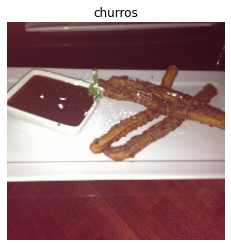

In [ ]:
# We can still plot our preprocessed image as long as we divide by 255 (for matplotlib capatibility)
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

# Batch & Prepare Datasets

Turn data into batches for memory efficiency

Leverage methods from tf.data API
* map() - maps predefined function to target dataset (e.g. preprocess_img() to image tensors)
* shuffle() - randomly shuffle elements of a target dataset
* batch() - turns element of a target dataset into batches
* prefetch() - prepares subsequent batches of data whilst other batches of data are being computed on
* Extra: cache() - saves elements in target dataset, saving loading time. (Cant use if dataset doesn't fit into memory)

Original dataset (e.g. train_data) -> map() -> shuffle() -> batch() -> prefetch() -> PrefetchDataset

In [ ]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# View prepared dataset
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

# Creating modelling callbacks

- Makes sure model's training logs are being tracked
- Make checkpoint saves after training milestones

- tf.keras.callbacks.TensorBoard() - keep track of model's training history
- tf.keras.callbacks.ModelCheckpoint() - save model's progress at various intervals to load and reuse without having to retrain

In [ ]:
# Create TensorBoard callback 
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = 'model_checkpoints/cp.ckpt'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                      monitor='val_accuracy', # Save model weights with best validation accuracy
                                                      save_best_only=True, # Save only the best weights
                                                      save_weights_only=True, # Only save model weights (not the entire model)
                                                      verbose=0) # Don't print out whether or not model is being saved

# Setup mixed precision training

- Mixed precision training involves using a mix of float16 and float32 tensors to make better use of GPU's memory (since GPU has limited memory and can only handle a number of float32 at the same time)
- Using less memory per tensor means more tensors can be computed on simultaneously




In [ ]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy(policy='mixed_float16') # Set flobal policy to mixed precision

In [ ]:
# Check global dtype policy (policy used by layers in the model)
mixed_precision.global_policy() # should output "mixed_float16" (if your GPU is compatible with mixed precision)

<Policy "mixed_float16">

Since global dtype policy is now 'mixed_float16', the model will automatically take advantage of float16 variables wherever possible (speed up training)

# Build feature extraction model

Typical order for using transfer learning:
1. Build a feature extraction model (replace top few layers of pretrained model)
2. Train for few epochs with lower layers frozen)
3. Fine-tune if necessary with multiple layers unfrozen

Before fine-tuning, its best practice to train a feature extraction model with custom top layers

## To build feature extraction model

- Use EfficientNetB0 from tf.keras.applications pre-trained on Imagenet as base model
  - download with include_top=False to create own output layer
- Freeze base model layer so we can use pre-learned patterns the base model has found on ImageNet
- Put together input, base mode, pooling and output layhers in a Functional model
- Compile the functional model using Adam optimizer and sparse categorical crossentrophy as the loss function (since labels aren't one-hot encoded)
- Fit model for 3 epochs using TensorBoard and ModelCheckpoint callbacks

*Note: Since we're using mixed precision training, our model needs a separated output layer with hardcoded dtype=float32 [e.g. 'layers.Activation("softmax", dtype=tf.float32)'] to make sure outputs of model are returned back to float32 (more numerically stable than float16)*

In [ ]:
from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Function model
inputs = layers.Input(shape=input_shape, name='input_layer')
# Since we're using EfficientNetB0 which has built in rescaling, dont need the following line:
#x = layers.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to ingerence mode only
x = layers.GlobalAveragePooling2D(name='pooling_layer')(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class
outputs = layers.Activation('softmax', dtype=tf.float32, name='softmax_float32')(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', # Using sparse_categorical_crosstentropy since labels are not one-hot-encoded
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

16705208/16705208 [==============================] - 1s 0us/step


In [ ]:
# Check out the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

# Checking layer dtype policies

In [ ]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy of each layers

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


Breaking down the info above:

- layer.name (str) : a layer's human-readable name, can be defined by the name parameter 
- layer.trainable (bool) : whether or not a layer is trainable (all of our layers are trainable except the efficientnetb0 layer since we set it's trainable attribute to False
- layer.dtype : the data type a layer stores its variables in
- layer.dtype_policy : the data type a layer computes in

*Note: A layer can have a dtype of float32 and a dtype policy of "mixed_float16" because it stores its variables (weights & biases) in float32 (more numerically stable), however it computes in float16 (faster).*

In [ ]:
# Check our model's base model

# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]: # only check the first 20 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
rescaling_1 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <

# Fit the feature extraction model

In [ ]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Fit the model with callbacks. Only evaluating on 15% of test data
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback('training_logs',
                                                                                            'efficientnetb0_101_classes_all_data_feature_extract'),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20230227-010532
Epoch 1/3
2368/2368 [==============================] - 237s 93ms/step - loss: 1.7163 - accuracy: 0.5834 - val_loss: 1.1296 - val_accuracy: 0.6999
Epoch 2/3
2368/2368 [==============================] - 232s 97ms/step - loss: 1.1989 - accuracy: 0.6884 - val_loss: 1.0312 - val_accuracy: 0.7190
Epoch 3/3
2368/2368 [==============================] - 222s 92ms/step - loss: 1.0529 - accuracy: 0.7242 - val_loss: 0.9952 - val_accuracy: 0.7293


In [ ]:
# Evaluate model (unsaved version) on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 55s 69ms/step - loss: 1.0008 - accuracy: 0.7293


[1.0007612705230713, 0.7293069362640381]

# Load and evaluate checkpoint weights

Load in and evaluate model's checkpoint by:
1. Cloning model using tf.keras.models.clone_model() to naje copy of feature extraction model with reset weights
2. Call load_weight() method on closed model passing it path where our checkpointed weights are stored
3. Call evaluate() on the clone model with loaded weights

In [ ]:
# Clone the model created (resets all the weights)
cloned_model = tf.keras.models.clone_model(model)
cloned_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
# Find location of checkpoints
checkpoint_path

'model_checkpoints/cp.ckpt'

In [ ]:
# Load checkpointed weights into cloned_model
cloned_model.load_weights(checkpoint_path)

Remember that everytime we make a change to model, we have to recompile

In [ ]:
# Compile cloned_model
cloned_model.compile(loss='sparse_categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
# Evaluate cloned model with loaded weight (should be same score as trained model)
results_cloned_model_with_loaded_weights = cloned_model.evaluate(test_data)

790/790 [==============================] - 58s 70ms/step - loss: 1.3672 - accuracy: 0.6339


# Preparing model's layer for fine tuning

In [ ]:
# Download the saved model from Google Storage (make sure model is consistent with the course)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip 

--2023-02-27 01:34:40--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.31.128, 142.250.145.128, 173.194.69.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16976857 (16M) [application/zip]
Saving to: ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  16.19M  15.9MB/s    in 1.0s    

2023-02-27 01:34:42 (15.9 MB/s) - ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’ saved [16976857/16976857]



In [ ]:
# Unzip the SavedModel downloaded from Google Stroage
!mkdir downloaded_gs_model # create new dirtory to store downloaded feature extraction model
!unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip -d downloaded_gs_model

Archive:  07_efficientnetb0_feature_extract_model_mixed_precision.zip
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.data-00000-of-00001  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.index  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/saved_model.pb  
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/assets/


In [ ]:
# Load and evaluate downloaded GS model
loaded_gs_model = tf.keras.models.load_model("downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision")

In [ ]:
# Get a summary of our downloaded model
loaded_gs_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
# How does the loaded model perform?
results_loaded_gs_model = loaded_gs_model.evaluate(test_data)
results_loaded_gs_model

790/790 [==============================] - 60s 74ms/step - loss: 1.0881 - accuracy: 0.7066


[1.0881004333496094, 0.7066138386726379]

When we initally created the model, we froze all layers in base model by setting base_model.trainable=False. Lets check if the download model is the same.


In [ ]:
# Are any of the layers in our model frozen?
for layer in loaded_gs_model.layers:
    layer.trainable = True # set all layers to trainable
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # make sure loaded model is using mixed precision dtype_policy ("mixed_float16")

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


Functional model with five layers
0. The input layer
1. The pre-trained base model layer (tf.keras.applications.EfficientNetB0)
2. The pooling layer
3. The fully connected (dense) layer
4. The ouput softmax activation (with float32 dtype)

In [ ]:
# Check the layers in the BASE MODEL and see what dtype policy they're using
for layer in loaded_gs_model.layers[1].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
normalization True float32 <Policy "float32">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "mixed_float

*Note: If you've got a small amount of data (less than 100 images per class), you may want to only unfreeze and fine-tune a small number of layers in the base model at a time. Otherwise, you risk overfitting. In our example, we have a lot of data (750 images x 101 training classes = 75750 training images) so we keep our base model's layers unfrozen*

# More callbacks

Might take a long time to train model. Usually want to stop when model stops improving but how can we tell? A solution is the 'EarlyStopping' callback.

The EarlyStopping callback monitors a specified model performance metric (e.g. val_loss) and when it stops improving for a specified number of epochs, automatically stops training.

Combine this with ModelCheckpoint callback that saves best performing models

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

Another callback to implement... ReduceLROnPlateau callback helps to tune the learning rate for you.

ReduceLROnPlateau callback montiors a specified metric and when that metric stops improving, it reduces the learning rate by a specified factor

In [ ]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7) # set minimum learning rate to prevent model not learning anything

Recompile model since we made changes

In [ ]:
# Compile the model
loaded_gs_model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

Begin fine-tuning! Run for 100 epochs (but may stop sooner since we're using EarlyStopping callback). Regardless, this may take a while....

In [ ]:
# Start to fine-tune (all layers)
history_101_food_classes_all_data_fine_tune = loaded_gs_model.fit(train_data,
                                                        epochs=100, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), # track the model training logs
                                                                   model_checkpoint, # save only the best model during training
                                                                   early_stopping, # stop model after X epochs of no improvements
                                                                   reduce_lr]) # reduce the learning rate after X epochs of no improvements

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20230227-014806
Epoch 1/100
 952/2368 [===========>..................] - ETA: 3:45 - loss: 0.9801 - accuracy: 0.7399

KeyboardInterrupt: ignored

In [ ]:
# Save model locally (note: if you're using Google Colab and you save your model locally, it will be deleted when your Google Colab session ends)
loaded_gs_model.save("07_efficientnetb0_fine_tuned_101_classes_mixed_precision")

# Download fine-tuned model from Google Storage

Training model can take significant amount of time so here is a model prepared ahead of time. Same as fine-tuned model created above but already saved to Google Storage to be used for evaluation

In [ ]:
# Download and evaluate fine-tuned model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip

--2023-02-27 01:52:47--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.128, 173.194.69.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46790356 (45M) [application/zip]
Saving to: ‘07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  44.62M  24.6MB/s    in 1.8s    

2023-02-27 01:52:49 (24.6 MB/s) - ‘07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip’ saved [46790356/46790356]



In [ ]:
# Unzip fine-tuned model
!mkdir downloaded_fine_tuned_gs_model # create separate directory for fine-tuned model downloaded from Google Storage
!unzip 07_efficientnetb0_fine_tuned_101_classes_mixed_precision -d downloaded_fine_tuned_gs_model

Archive:  07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip
   creating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/
   creating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/variables/
  inflating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/variables/variables.data-00000-of-00001  
  inflating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/variables/variables.index  
  inflating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/saved_model.pb  
   creating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/assets/


In [ ]:
# Load in fine-tuned model from Google Storage and evaluate
loaded_fine_tuned_gs_model = tf.keras.models.load_model("downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision")

In [ ]:
# Get a model summary (same model architecture as above)
loaded_fine_tuned_gs_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 4,136,929
Non-train

In [ ]:
# Note: Even if you're loading in the model from Google Storage, you will still need to load the test_data variable for this cell to work
results_downloaded_fine_tuned_gs_model = loaded_fine_tuned_gs_model.evaluate(test_data)
results_downloaded_fine_tuned_gs_model

790/790 [==============================] - 75s 94ms/step - loss: 0.9072 - accuracy: 0.8015


[0.9072167873382568, 0.8014653325080872]

# RESULTS!!!!

Our model got an accuracy of around 80% which is better than the DeepFood (77%)research paper!

Other ways to improve results
- Change to a different EfficientNet Model (e.g. EfficientNetB4)
- Unfreezing less layers of base model and training them rather than unfreezing all layers in one go

# Viewing results on TensorBoard

In [ ]:
# Upload experiment results to TensorBoard
!tensorboard dev upload --logdir ./training_logs \
  --name "Fine-tuning EfficientNetB0 on all Food101 Data" \
  --description "Training results for fine-tuning EfficientNetB0 on Food101 Data with learning rate 0.0001" \
  --one_shot

2023-02-27 01:55:07.221733: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-27 01:55:07.227700: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-27 01:55:07.227725: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./training_logs

This TensorBoard 